# Creating a gold standard from existing Taboo cards

## Reading in and formatting the cards

The Taboo cards that our gold standard will be based on belong to Elizabeth's Canadian edition of Taboo, produced sometime in the 1990s or early 2000s.

In [7]:
FILENAME = "taboo_cards.txt"


def read_in(filename):
    """
    Reads in transcribed Taboo card words contained in the given file and returns them in an enumerated list.
    """
    file_lines = []
    
    with open(filename, "r", encoding='utf-8') as myfile:
        
        # Go through every line, saving non-empty ones to the list file_lines.
        for line in myfile:
            if line.strip() != '':             
                file_lines.append(line.strip()) 
                
    return list(enumerate(file_lines))
    
            
def format_cards(enum_list):
    """
    Given an enumerated list (output of read_in()), formats the contents as a dictionary (key = MW, values = list of TWs)
    """
    
    # Initialise dictionary to contain card data.
    card_dict = dict()
    
    # Assign MWs (every sixth word in the enumerated list) as dictionary keys, and create a list for the dict's
    # value consisting of the five following words (the TWs); the word[1:] removes the dash from the beginning of
    # each TW's string.

    for enum, wd in enum_list:
        if enum % 6 == 0:
            card_dict[wd] = [word[1:] for num, word in enum_list[enum+1:enum+6]]
        
    return card_dict
        

enum_lines = read_in(FILENAME)
cards = format_cards(enum_lines)

In [8]:
# Example: the five TWs from the MW 'syrup'
cards['syrup']

['maple', 'pancakes', 'trees', 'sap', 'sweet']

In [36]:
len(cards)

240

In addition to this dictionary format, it will be helpful to set up a pandas dataframe for easy addition of columns for semantic similarity and corpus-based collocation measures below.

In [57]:
import pandas as pd
import numpy as np

In [47]:
# Create a pandas dataframe quickly based on a list of dictionaries, with each dictionary corresponding to a row in the 
# dataframe.
# ( Source: https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe/17496530#17496530 )

rows_list = []

for mainwd, tabwds in cards.items():
    for tabwd in tabwds:
        
        # Create a dictionary for each row of the dataframe (key = column name, value = row value for that column)
        row = {
            'mw': mainwd,
            'tw': tabwd
        }
        
        # Append to rows_list, and use that list as a basis for the new dataframe.
        rows_list.append(row)

data = pd.DataFrame(rows_list)
data.head()

,mw,tw
0,huddle,gather
1,huddle,football
2,huddle,group
3,huddle,play
4,huddle,together


## Computing semantic similarity with gensim

In [9]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [58]:
def add_similarity_to_df(df):
    """
    Computes the similarity between the MW in the first column and the TW in the second of the passed-in dataframe.
    
    Args:
        df: dataframe containing cleaned corpus data
        
    Returns:
        A dataframe with a new column 'simil' containing word2vec similarity values
    """
    
    # Initialise empty list to collect similarity values as we go.
    simil_col=[]
    
    # Iterate through rows in the dataframe.
    for row_idx in range(len(df)):
        
        # Get the MW and the TW in the current row.
        mw = df.loc[row_idx, ['mw']][0]
        tw = df.loc[row_idx, ['tw']][0]
        
        # KeyError raised if word not in the word2vec vocabulary, so if that happens, add numpy's null value
        # to the column instead.
        try:
            value = model.similarity(mw, tw)
        except KeyError:
            value = np.nan
        
        # Add similarity value to the list. At the end, this list will be of the same length
        # as the dataframe and will contain a similarity value (or NA) for each adjective pair.
        simil_col.append(value)
    
    # Add this list as a new column to the dataframe and return dataframe.
    df['simil'] = simil_col
    
    return df


data = add_similarity_to_df(data)

In [73]:
# For example
data[data['mw'] == 'syrup']

,mw,tw,simil
195,syrup,maple,0.481212
196,syrup,pancakes,0.452126
197,syrup,trees,0.229673
198,syrup,sap,0.407497
199,syrup,sweet,0.354979


### Describing the data

In [61]:
# Null values

data.isnull().sum()

mw         0
tw         0
simil    152
dtype: int64

In [77]:
# We can look at how the data are distributed

data.describe()

,simil
count,1048.000000
mean,0.316603
std,0.171891
min,-0.081147
25%,0.186880
50%,0.297276
75%,0.424291
max,0.850191


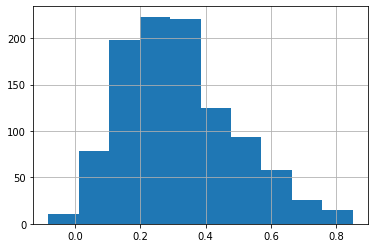

In [65]:
data['simil'].hist();

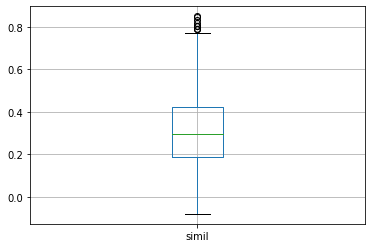

In [79]:
data.boxplot();

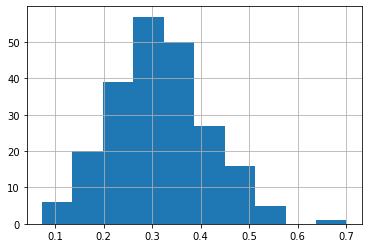

In [75]:
# Mean similarity for each MW

mean_simil_by_mw = data.groupby('mw').mean()['simil']
mean_simil_by_mw.hist();

In [74]:
# silly plot because it has 240 boxes lol
# data.boxplot(column='simil', by='mw', figsize=(18, 16));

- things we have learned: 
    - most TWs only have a similarity between 0.2 and 0.4
    - will this go up if I exclude the ones with semantic similarity below a certain threshold and look at collocates for those ones instead?
    - will probably get a different distribution if, for our main words, we choose the most similar ones to include
    - I'm not going to be terribly sad if we don't get the exact same distribution though ... this is mostly just to make sure that we're not wildly off the mark
- sample from all words with similarity between .2 and .4 (or whatever range we decide -- consider weeding out lower similarity ones and looking at similarity of words that are already more similar)
- put two with high similarity, say, into the set to pull from

## Computing collocation measures

- I will have to do all the queries on the SeaCOW server, export everything to csv, and import it into this script, I guess, so this project won't be totally replicable by anyone who doesn't have SeaCOW access
- do the $O_{ij}$ and $E_{ij}$ (marginal frequency) calculations on server, even if don't want to use statistical collocation measures -- can go from that to just $O$ and $E$, but not vice versa

## WordNet semantic relations

- antonyms, hypernyms, hyponyms

In [4]:
import taboo

taboo.cats(x)

SyntaxError: invalid syntax (<ipython-input-4-a316172a8576>, line 1)